In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
( train_ds , test_ds ), ds_info = tfds.load('mnist', split =['train','test'], as_supervised=True, with_info=True)

In [ ]:
batchsize = 128

In [ ]:
def prepare_mnist_data(ds):
  # Transform the dataset by mapping each element (feature_dict) to a tuple containing the "image" and "label" components.
  #ds = ds.map(lambda feature_dict: (feature_dict["image"], feature_dict["label"]))

  # Reshape the images by mapping each element (image, label) to a tuple with the image reshaped to a 1D vector and the label.
  ds = ds.map(lambda image, label: (tf.reshape(image, (-1,)), label))

  # Scale and normalize the images to the range [-1, 1] by mapping each element (image, label) to a tuple.
  # This is done by casting the image to float32 and dividing by 128, then subtracting 1.
  ds = ds.map(lambda image, label: ((tf.cast(image, tf.float32)/128)-1, label))

  # Filter the dataset to only include examples with a label < 5 by mapping each element (image, label) to a tuple.
  ds = ds.filter(lambda image, label: label < 5)

  # One-hot encode the labels by mapping each element (image, label) to a tuple where the label is one-hot encoded with depth 10.
  ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth=10)))

  # Shuffle the dataset with a buffer size of 1024 and batch the shuffled data into batches of size 256.
  ds = ds.shuffle(1024).batch(batchsize)

  # Prefetch the data to improve performance by overlapping data preprocessing and model execution.
  ds = ds.prefetch(4)
  return ds

In [ ]:
train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

batchsize = 500

train_dataset1 = train_ds.apply(prepare_mnist_data)
test_dataset1 = test_ds.apply(prepare_mnist_data)

batchsize = 1000

train_dataset2 = train_ds.apply(prepare_mnist_data)
test_dataset2 = test_ds.apply(prepare_mnist_data)

batchsize = 20

train_dataset3 = train_ds.apply(prepare_mnist_data)
test_dataset3 = test_ds.apply(prepare_mnist_data)

In [ ]:
#Define the MLP Model
class MLP_Model(tf.keras.Model):
  def __init__(self, layer_sizes, output_size=10):
    super().__init__()
    self.mlp_layers = []

    for layer_size in layer_sizes:
      new_layer = tf.keras.layers.Dense(units=layer_size, activation="sigmoid")
      self.mlp_layers.append(new_layer)
    self.output_layer = tf.keras.layers.Dense(units=output_size, activation="softmax")

  def call(self, x):
    for layer in self.mlp_layers:
      x = layer(x)
    y = self.output_layer(x)
    return y

In [ ]:
def train_test_mnist_model(train_ds, test_ds, model, loss_func, optimizer, num_epochs):
  # Initialize lists to store training and test loss and accuracy
  train_loss_list = []
  train_accuracy_list = []
  test_loss_list = []
  test_accuracy_list = []

  # Initialize the accuracy metrics
  train_accuracy_metric = tf.keras.metrics.Accuracy()
  test_accuracy_metric = tf.keras.metrics.Accuracy()

  for epoch in range(num_epochs):
    # Training
    total_train_loss = 0.0
    train_accuracy_metric.reset_states()

    for inputs, labels in train_ds:
        with tf.GradientTape() as tape:
            outputs = model(inputs)
            train_loss = loss_func(labels, outputs)

        gradients = tape.gradient(train_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        total_train_loss += train_loss.numpy()
        train_accuracy_metric.update_state(tf.argmax(labels, axis=1), tf.argmax(outputs, axis=1))

    average_train_loss = total_train_loss / len(train_ds)
    train_accuracy = train_accuracy_metric.result().numpy()

    # Testing
    total_test_loss = 0.0
    test_accuracy_metric.reset_states()

    for test_inputs, test_labels in test_ds:
        test_outputs = model(test_inputs)
        test_loss = loss_func(test_labels, test_outputs)

        total_test_loss += test_loss.numpy()
        test_accuracy_metric.update_state(tf.argmax(test_labels, axis=1), tf.argmax(test_outputs, axis=1))

    average_test_loss = total_test_loss / len(test_ds)
    test_accuracy = test_accuracy_metric.result().numpy()

    # Print or log the values
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Store values for plotting
    train_loss_list.append(average_train_loss)
    train_accuracy_list.append(train_accuracy)
    test_loss_list.append(average_test_loss)
    test_accuracy_list.append(test_accuracy)

  return (train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list)


In [ ]:
model = MLP_Model([256,256])
model1 = MLP_Model([64,32])
model2 = MLP_Model([25,25])
model3 = MLP_Model([20])
model4 = MLP_Model([1])

cce = tf.keras.losses.CategoricalCrossentropy()
optimizer_SDF = tf.keras.optimizers.legacy.SGD(learning_rate=0.1)

ds = train_dataset
test_ds = test_dataset
num_epochs = 10



In [ ]:
def visualization_og(train_losses, train_accuracies, test_losses, test_accuracies, name):
    """Visualizes accuracy and loss for training and test data using
    the mean of each epoch.
    Loss is displayed in a regular line, accuracy in a dotted
    line.
    Training data is displayed in blue, test data in red.
    Parameters
    ----------
    train_losses : numpy.ndarray
    training losses
    train_accuracies : numpy.ndarray
    training accuracies
    test_losses : numpy.ndarray
    test losses
    test_accuracies : numpy.ndarray
    test accuracies
    """
    plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(test_losses, "r-")
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(test_accuracies, "r:")
    plt.xlabel("Training steps")
    plt.ylabel("Loss / Accuracy")
    plt.title(name)
    plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()

In [ ]:
def visualization(ax, train_losses, train_accuracies, test_losses, test_accuracies, name):
    """Adds accuracy and loss subplots for training and test data using
    the mean of each epoch to an existing subplot.
    Loss is displayed in a regular line, accuracy in a dotted
    line.
    Training data is displayed in blue, test data in red.
    Parameters
    ----------
    ax : matplotlib.axes._subplots.AxesSubplot
        Existing subplot to which the new subplots will be added.
    train_losses : numpy.ndarray
        Training losses
    train_accuracies : numpy.ndarray
        Training accuracies
    test_losses : numpy.ndarray
        Test losses
    test_accuracies : numpy.ndarray
        Test accuracies
    name : str
        Title for the subplots
    """
    # Plot training and test losses
    ax.plot(train_losses, "b-", label="Training Loss")
    ax.plot(test_losses, "r-", label="Test Loss")

    # Plot training and test accuracies
    ax.plot(train_accuracies, "b:", label="Training Accuracy")
    ax.plot(test_accuracies, "r:", label="Test Accuracy")

    # Set labels and title
    ax.set_xlabel("Training steps")
    ax.set_ylabel("Loss / Accuracy")
    ax.set_title(name)

    # Add legends
    ax.legend()

In [ ]:
def diffrent_Layers():
    #Diffrent models with diffrent layers SDG
    print("Model 0, SDG")
    (train_loss_list0_0, train_accuracy_list0_0, test_loss_list0_0, test_accuracy_list0_0) = train_test_mnist_model(train_dataset, test_dataset, model, cce, optimizer_SDF, num_epochs)
    print("Model 1, SDG")
    (train_loss_list0_1, train_accuracy_list0_1, test_loss_list0_1, test_accuracy_list0_1) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, optimizer_SDF, num_epochs)
    print("Model 2, SDG")
    (train_loss_list0_2, train_accuracy_list0_2, test_loss_list0_2, test_accuracy_list0_2) = train_test_mnist_model(train_dataset, test_dataset, model2, cce, optimizer_SDF, num_epochs)
    print("Model 3, SDG")
    (train_loss_list0_3, train_accuracy_list0_3, test_loss_list0_3, test_accuracy_list0_3) = train_test_mnist_model(train_dataset, test_dataset, model3, cce, optimizer_SDF, num_epochs)
    print("Model 4, SDG")
    (train_loss_list0_4, train_accuracy_list0_4, test_loss_list0_4, test_accuracy_list0_4) = train_test_mnist_model(train_dataset, test_dataset, model4, cce, optimizer_SDF, num_epochs)

    fig, ((existing_ax_1_0, existing_ax_1_1), (existing_ax_1_2, existing_ax_1_3)) = plt.subplots(2,2)
    fig.suptitle("Diffrent models with diffrent layers SDG")
    fig.set_size_inches(50, 50)
    visualization(existing_ax_1_0, train_loss_list0_1, train_accuracy_list0_1, test_loss_list0_1, test_accuracy_list0_1, name="Model 1")
    visualization(existing_ax_1_1, train_loss_list0_2, train_accuracy_list0_2, test_loss_list0_2, test_accuracy_list0_2, name="Model 2")
    visualization(existing_ax_1_2, train_loss_list0_3, train_accuracy_list0_3, test_loss_list0_3, test_accuracy_list0_3, name="Model 3")
    visualization(existing_ax_1_3, train_loss_list0_4, train_accuracy_list0_4, test_loss_list0_4, test_accuracy_list0_4, name="Model 4")


#diffrent_Layers()

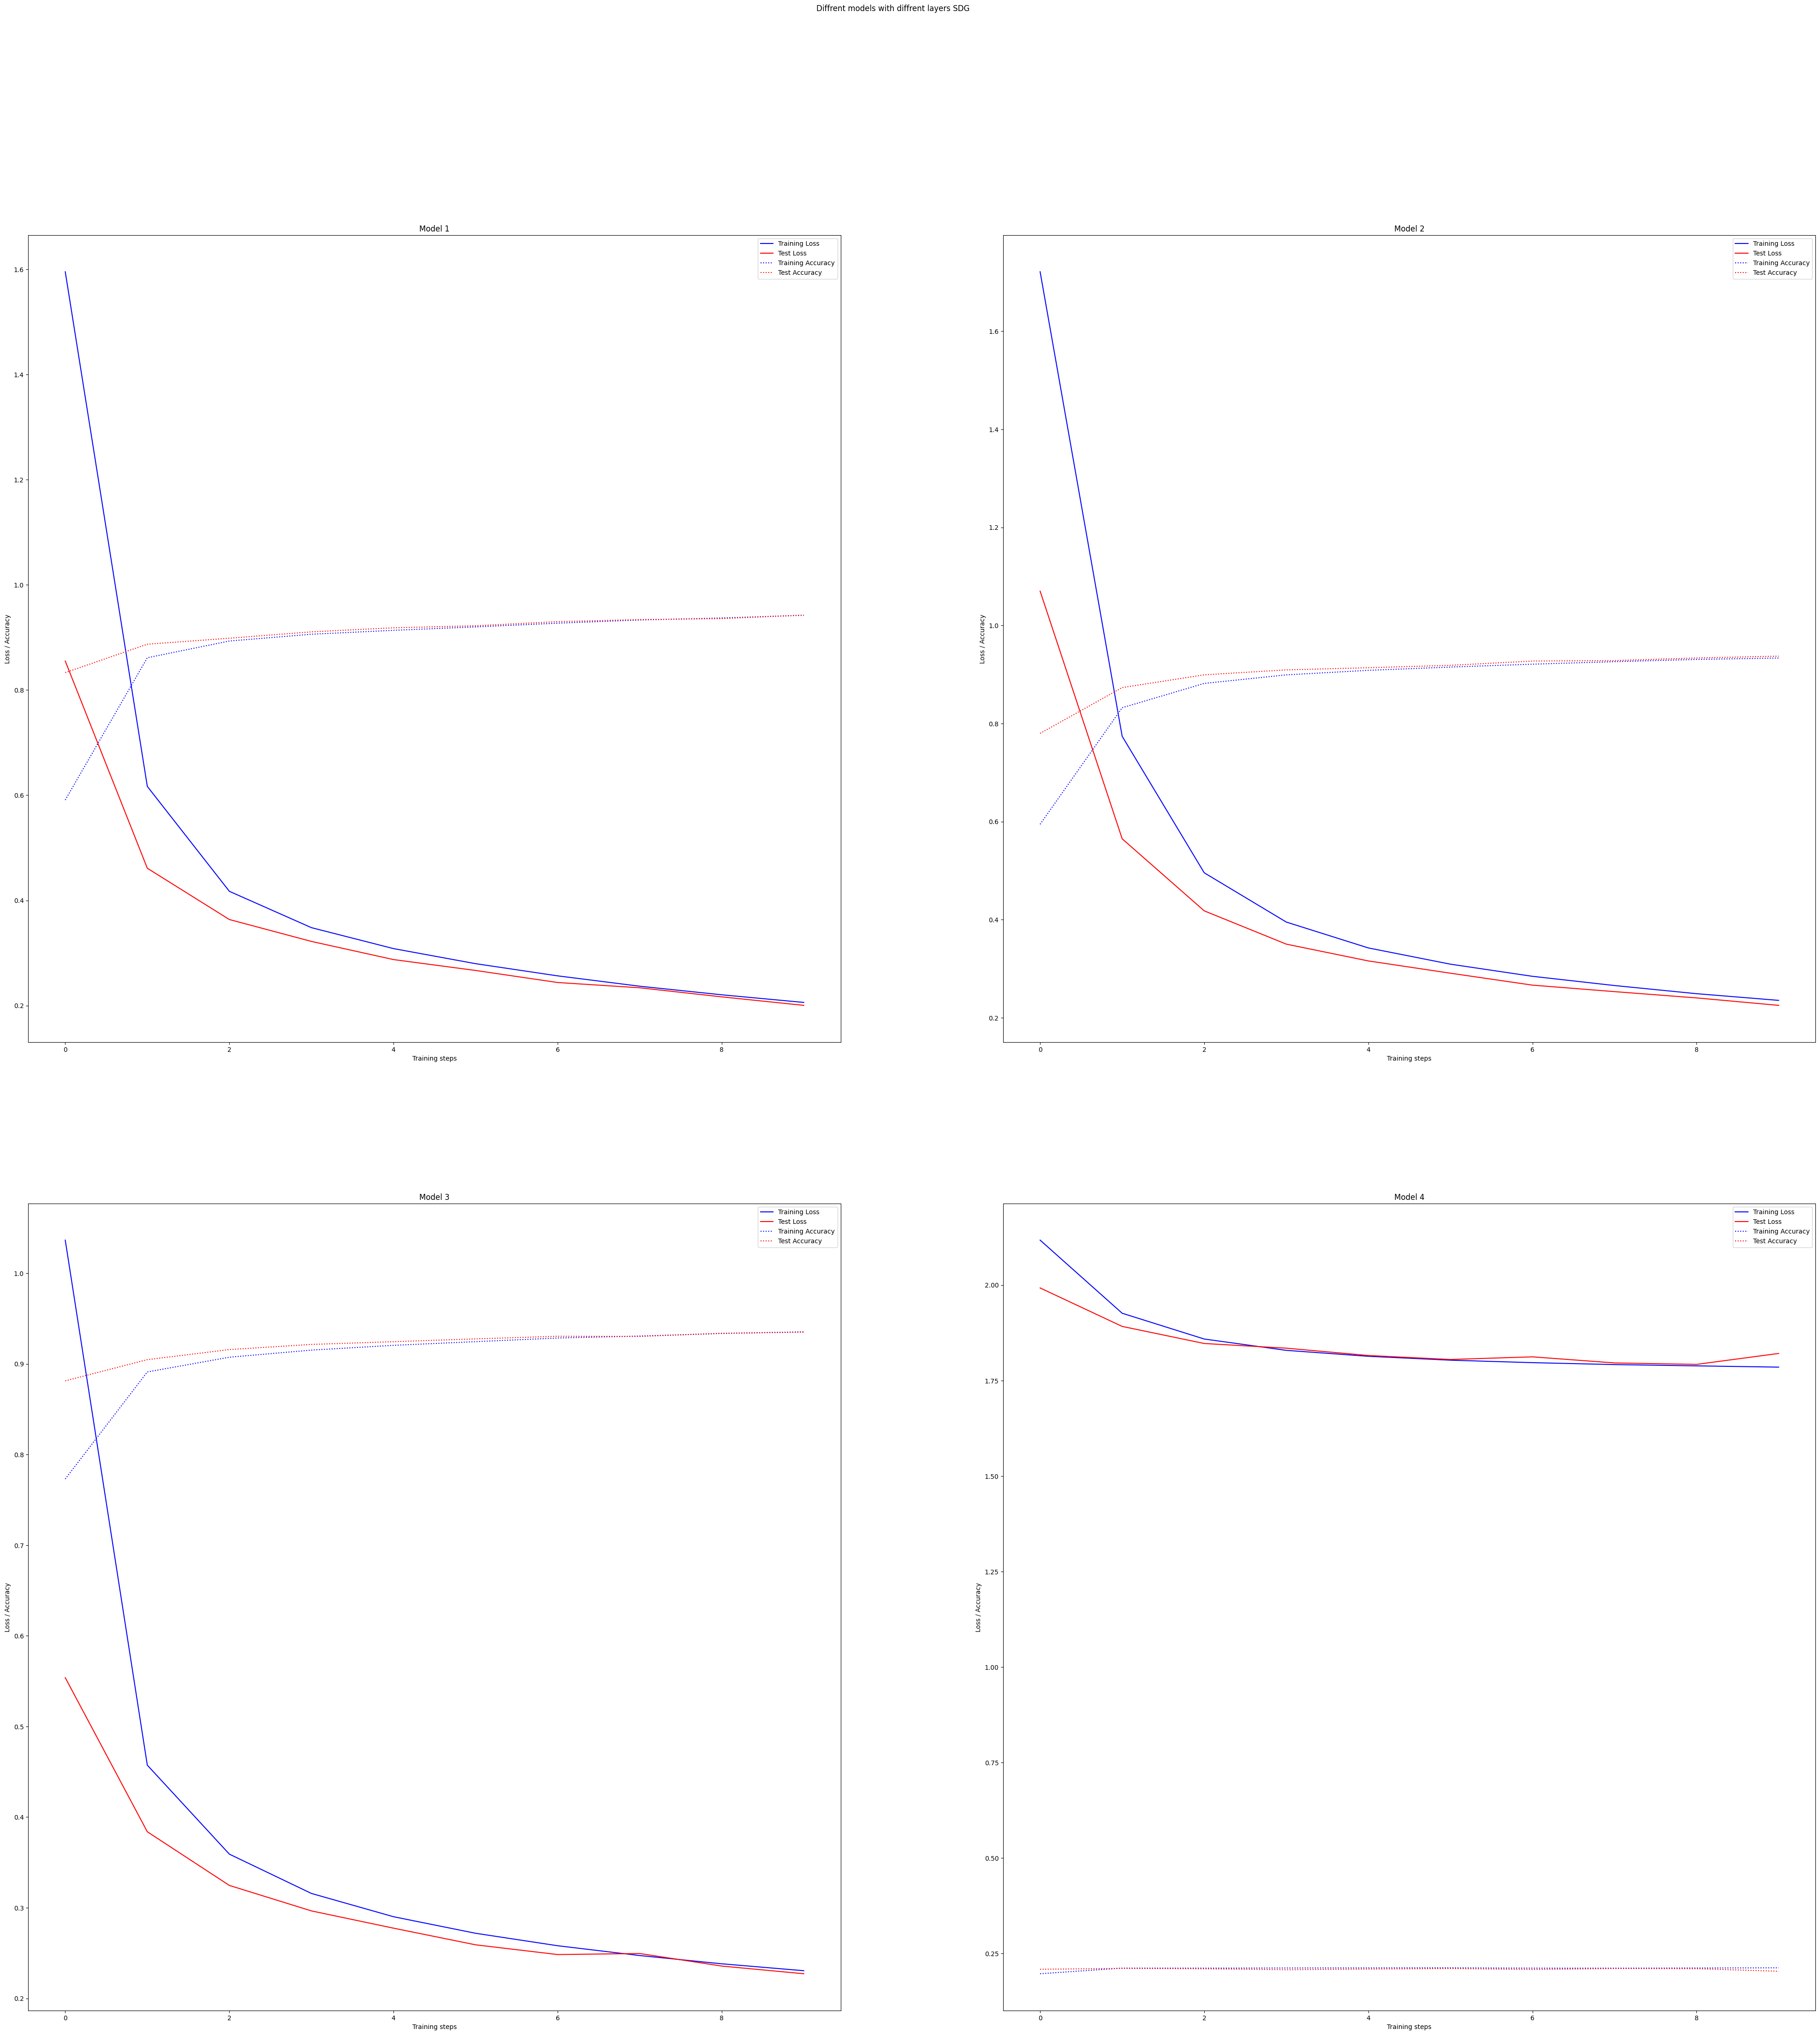

In [ ]:
def diffrent_Optimisers():
    optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.1)
    optimizer_rmsprop = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.1)
    optimizer_adadelta = tf.keras.optimizers.legacy.Adadelta(learning_rate=0.1)

    #Diffrent optimiseres with same layer
    print("SDG_Model_1")
    (train_loss_list1_0, train_accuracy_list1_O, test_loss_list1_O, test_accuracy_list1_O) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, optimizer_SDF, num_epochs)
    print("Adam_Model_1")
    (train_loss_list1_1, train_accuracy_list1_1, test_loss_list1_1, test_accuracy_list1_1) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, optimizer_adam, num_epochs)
    print("RMSprop_Model_1")
    (train_loss_list1_2, train_accuracy_list1_2, test_loss_list1_2, test_accuracy_list1_2) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, optimizer_rmsprop, num_epochs)
    print("Adadelta_Model_1")
    (train_loss_list1_3, train_accuracy_list1_3, test_loss_list1_3, test_accuracy_list1_3) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, optimizer_adadelta, num_epochs)

    fig2, ((existing_ax_2_0, existing_ax_2_1), (existing_ax_2_2, existing_ax_2_3)) = plt.subplots(2,2)
    fig2.set_size_inches(50, 50)
    fig2.suptitle("Diffrent optimisers with same layer")
    visualization(existing_ax_2_0, train_loss_list1_0, train_accuracy_list1_O, test_loss_list1_O, test_accuracy_list1_O, name="SDG_Model")
    visualization(existing_ax_2_1, train_loss_list1_1, train_accuracy_list1_1, test_loss_list1_1, test_accuracy_list1_1, name="Adam_Model")
    visualization(existing_ax_2_2, train_loss_list1_2, train_accuracy_list1_2, test_loss_list1_2, test_accuracy_list1_2, name="RMSprop_Model")
    visualization(existing_ax_2_3, train_loss_list1_3, train_accuracy_list1_3, test_loss_list1_3, test_accuracy_list1_3, name="Adadelta_Model")

#diffrent_Optimisers()

The reason for the bad results regarding the other(not SDG) optimisers is most likly connected to a wrong, for them, implementation of a MLP
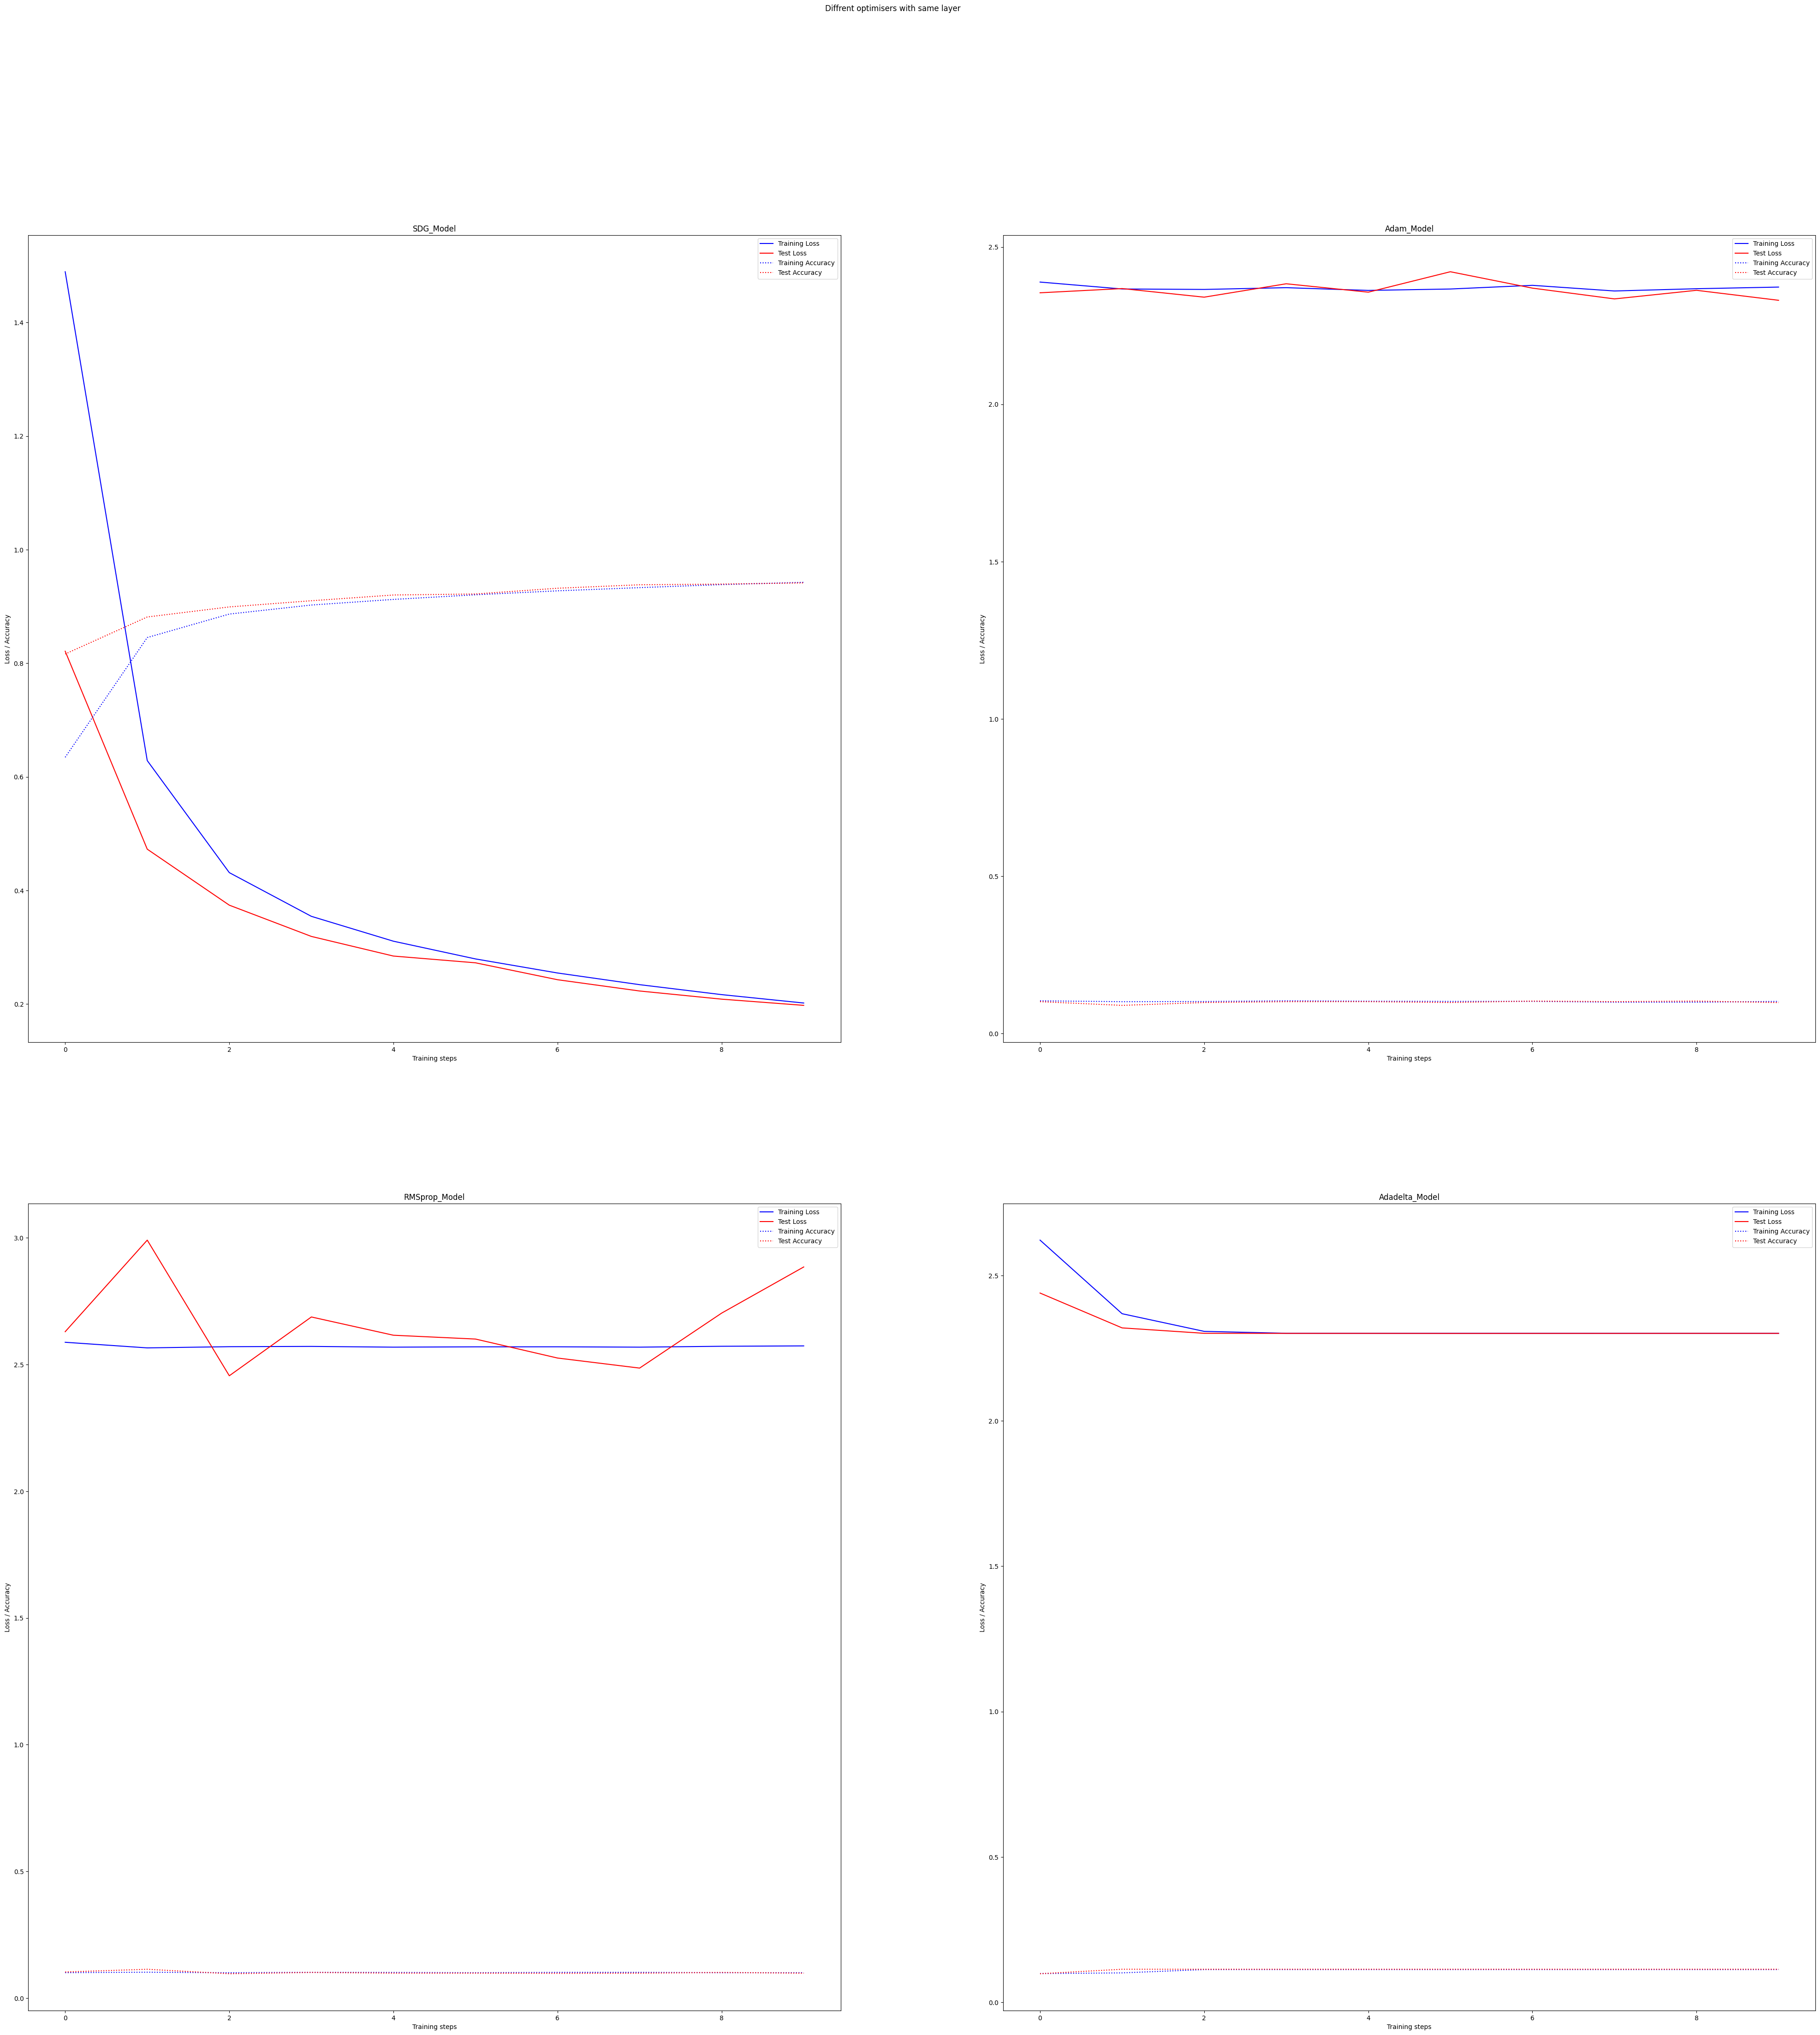

In [ ]:
def diffrent_Learning_Rates():
    #SDG with diffrent learning rate
    print("SDG_Model_1_learning_rate_0.1")
    (train_loss_list2_0, train_accuracy_list2_0, test_loss_list2_0, test_accuracy_list2_0) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, optimizer_SDF, num_epochs)
    print("SDG_Model_1_learning_rate_0.01")
    (train_loss_list2_1, train_accuracy_list2_1, test_loss_list2_1, test_accuracy_list2_1) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, tf.keras.optimizers.legacy.SGD(learning_rate=0.01), num_epochs)
    print("SDG_Model_1_learning_rate_0.001")
    (train_loss_list2_2, train_accuracy_list2_2, test_loss_list2_2, test_accuracy_list2_2) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, tf.keras.optimizers.legacy.SGD(learning_rate=0.001), num_epochs)
    print("SDG_Model_1_learning_rate_5")
    (train_loss_list2_3, train_accuracy_list2_3, test_loss_list2_3, test_accuracy_list2_3) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, tf.keras.optimizers.legacy.SGD(learning_rate=5), num_epochs)

    fig3, ((existing_ax_3_0, existing_ax_3_1), (existing_ax_3_2, existing_ax_3_3)) = plt.subplots(2,2)
    fig3.suptitle("SDG with different learning rate")
    fig3.set_size_inches(50, 50)
    plt.xlim(0, 5)

    visualization(existing_ax_3_0, train_loss_list2_0, train_accuracy_list2_0, test_loss_list2_0, test_accuracy_list2_0, name="SDG_Model_1_learning_rate_0.1")
    visualization(existing_ax_3_1, train_loss_list2_1, train_accuracy_list2_1, test_loss_list2_1, test_accuracy_list2_1, name="SDG_Model_1_learning_rate_0.01")
    visualization(existing_ax_3_2, train_loss_list2_2, train_accuracy_list2_2, test_loss_list2_2, test_accuracy_list2_2, name="SDG_Model_1_learning_rate_0.001")
    visualization(existing_ax_3_3, train_loss_list2_3, train_accuracy_list2_3, test_loss_list2_3, test_accuracy_list2_3, name="SDG_Model_1_learning_rate_5")

#diffrent_Learning_Rates()

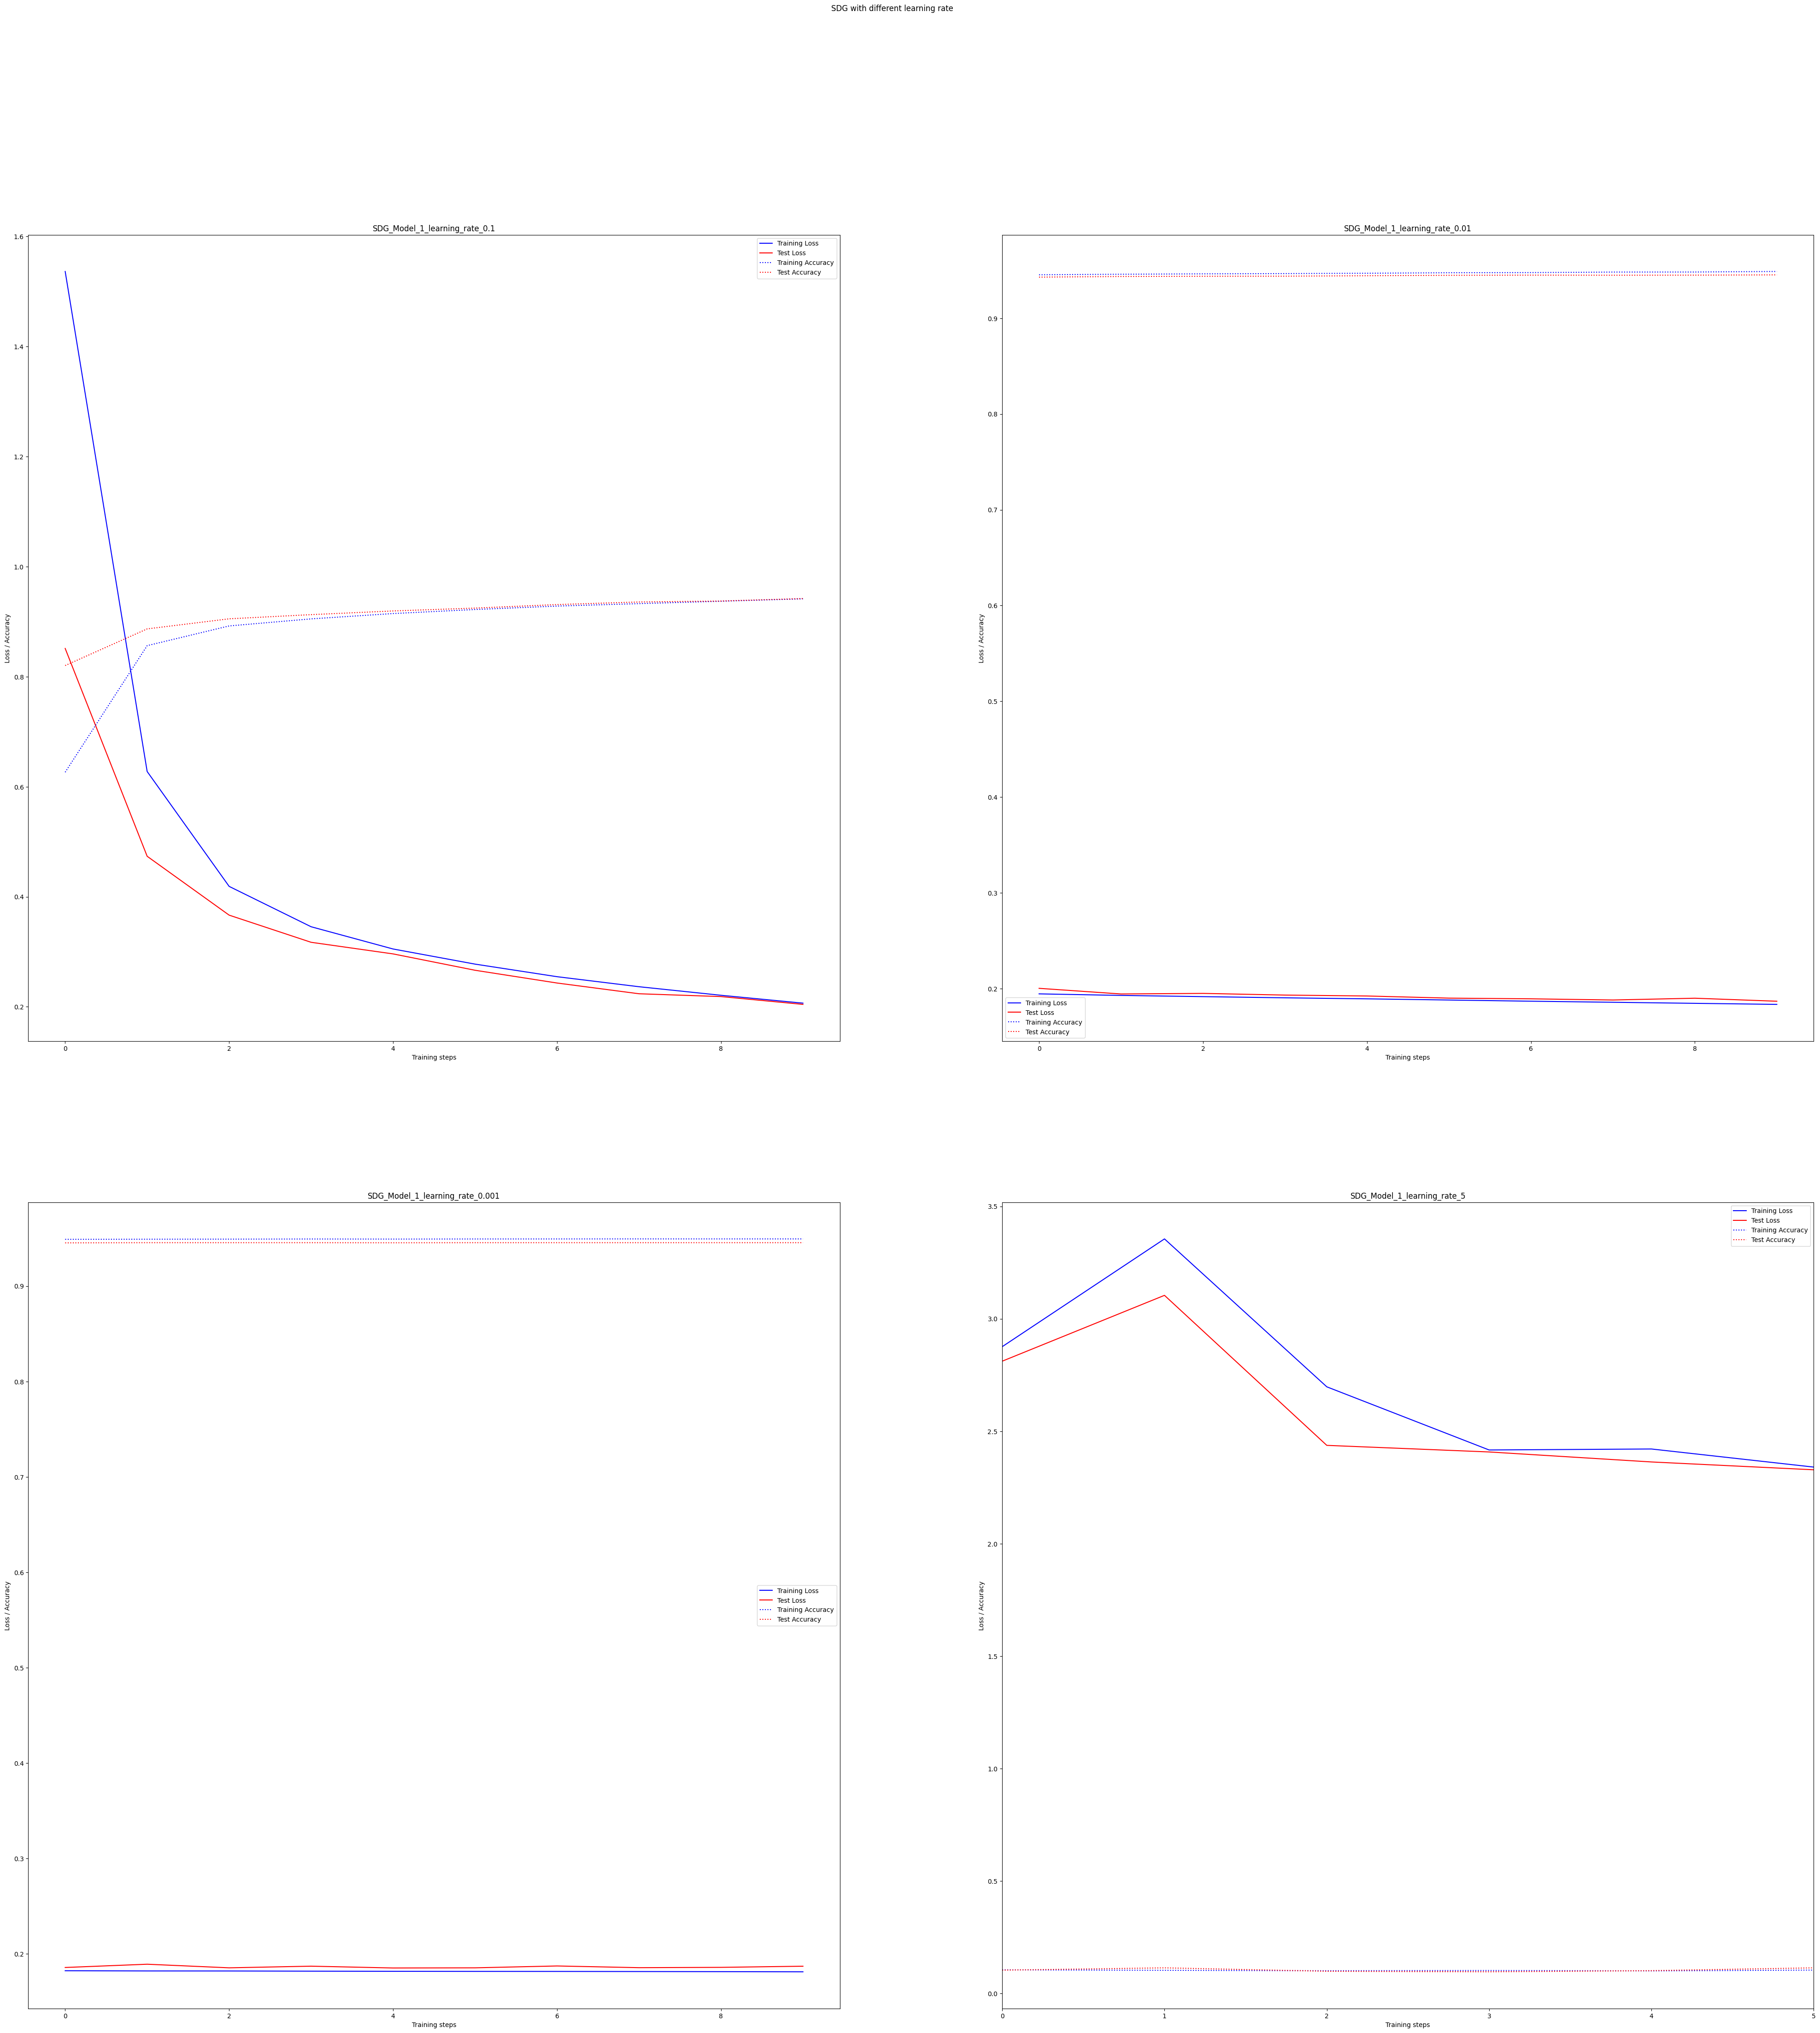

In [ ]:
def diffrent_momentum():
    #SDG with diffrent momentum
    print("SDG_Model_1_momentum_0.1")
    (train_loss_list3_0, train_accuracy_list3_0, test_loss_list3_0, test_accuracy_list3_0) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.1), num_epochs)
    print("SDG_Model_1_momentum_0.5")
    (train_loss_list3_1, train_accuracy_list3_1, test_loss_list3_1, test_accuracy_list3_1) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.5), num_epochs)
    print("SDG_Model_1_momentum_0.9")
    (train_loss_list3_2, train_accuracy_list3_2, test_loss_list3_2, test_accuracy_list3_2) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.9), num_epochs)
    print("SDG_Model_1_momentum_0.99")
    (train_loss_list3_3, train_accuracy_list3_3, test_loss_list3_3, test_accuracy_list3_3) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.99), num_epochs)

    fig4, ((existing_ax_4_0, existing_ax_4_1), (existing_ax_4_2, existing_ax_4_3)) = plt.subplots(2,2)
    fig4.suptitle("SDG with different momentum")
    fig4.set_size_inches(50, 50)
    visualization(existing_ax_4_0, train_loss_list3_0, train_accuracy_list3_0, test_loss_list3_0, test_accuracy_list3_0, name="SDG_momentum_0.1")
    visualization(existing_ax_4_1, train_loss_list3_1, train_accuracy_list3_1, test_loss_list3_1, test_accuracy_list3_1, name="SDG_momentum_0.5")
    visualization(existing_ax_4_2, train_loss_list3_2, train_accuracy_list3_2, test_loss_list3_2, test_accuracy_list3_2, name="SDG_momentum_0.9")
    visualization(existing_ax_4_3, train_loss_list3_3, train_accuracy_list3_3, test_loss_list3_3, test_accuracy_list3_3, name="SDG_momentum_0.99")

#diffrent_momentum()

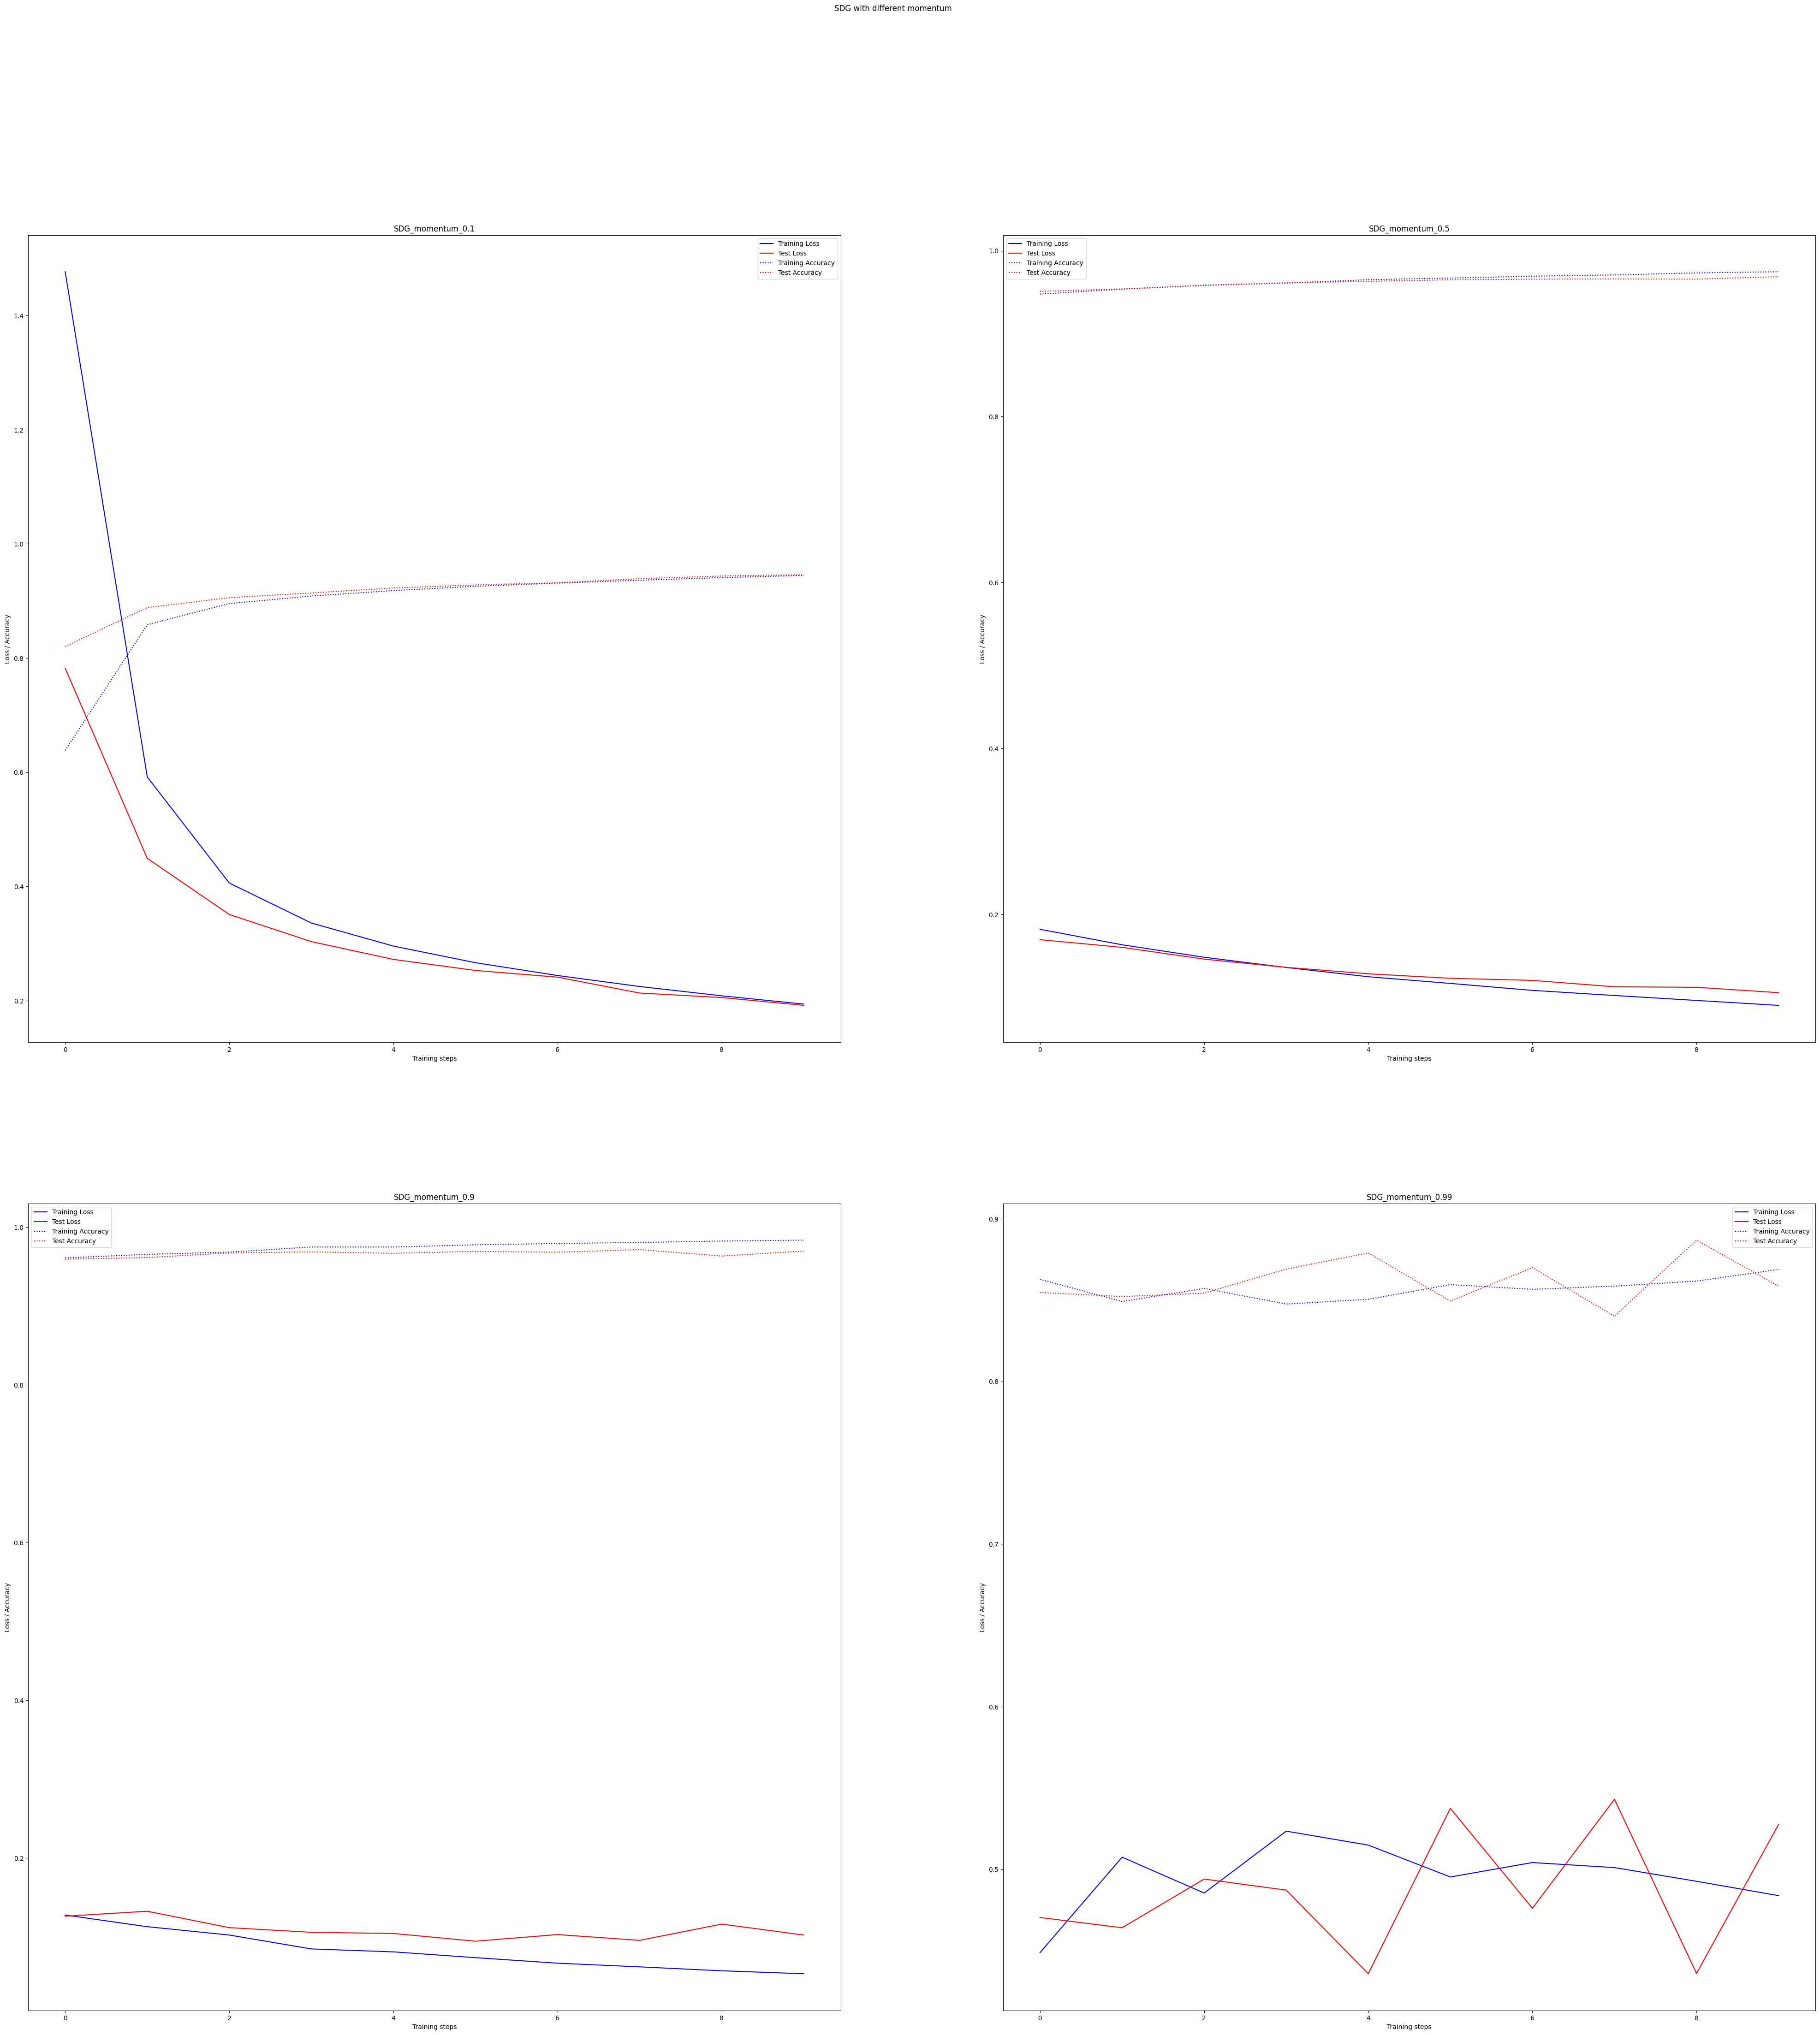

In [ ]:
def diffrent_batch_size():
    #SDG with diffrent batch size
    print("SDG_Model_1_batch_size_128")
    (train_loss_list4_0, train_accuracy_list4_0, test_loss_list4_0, test_accuracy_list4_0) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, optimizer_SDF, num_epochs)
    print("SDG_Model_1_batch_size_500")
    (train_loss_list4_1, train_accuracy_list4_1, test_loss_list4_1, test_accuracy_list4_1) = train_test_mnist_model(train_dataset1, test_dataset1, model1, cce, optimizer_SDF, num_epochs)
    print("SDG_Model_1_batch_size_1000")
    (train_loss_list4_2, train_accuracy_list4_2, test_loss_list4_2, test_accuracy_list4_2) = train_test_mnist_model(train_dataset2, test_dataset2, model1, cce, optimizer_SDF, num_epochs)
    print("SDG_Model_1_batch_size_20")
    (train_loss_list4_3, train_accuracy_list4_3, test_loss_list4_3, test_accuracy_list4_3) = train_test_mnist_model(train_dataset3, test_dataset3, model1, cce, optimizer_SDF, num_epochs)

    fig5, ((existing_ax_5_0, existing_ax_5_1), (existing_ax_5_2, existing_ax_5_3)) = plt.subplots(2,2)
    fig5.suptitle("SDG with different batch size")
    fig5.set_size_inches(50, 50)
    visualization(existing_ax_5_0, train_loss_list4_0, train_accuracy_list4_0, test_loss_list4_0, test_accuracy_list4_0, name="SDG_batch_size_128")
    visualization(existing_ax_5_1, train_loss_list4_1, train_accuracy_list4_1, test_loss_list4_1, test_accuracy_list4_1, name="SDG_batch_size_500")
    visualization(existing_ax_5_2, train_loss_list4_2, train_accuracy_list4_2, test_loss_list4_2, test_accuracy_list4_2, name="SDG_batch_size_1000")
    visualization(existing_ax_5_3, train_loss_list4_3, train_accuracy_list4_3, test_loss_list4_3, test_accuracy_list4_3, name="SDG_batch_size_20")

#diffrent_batch_size()

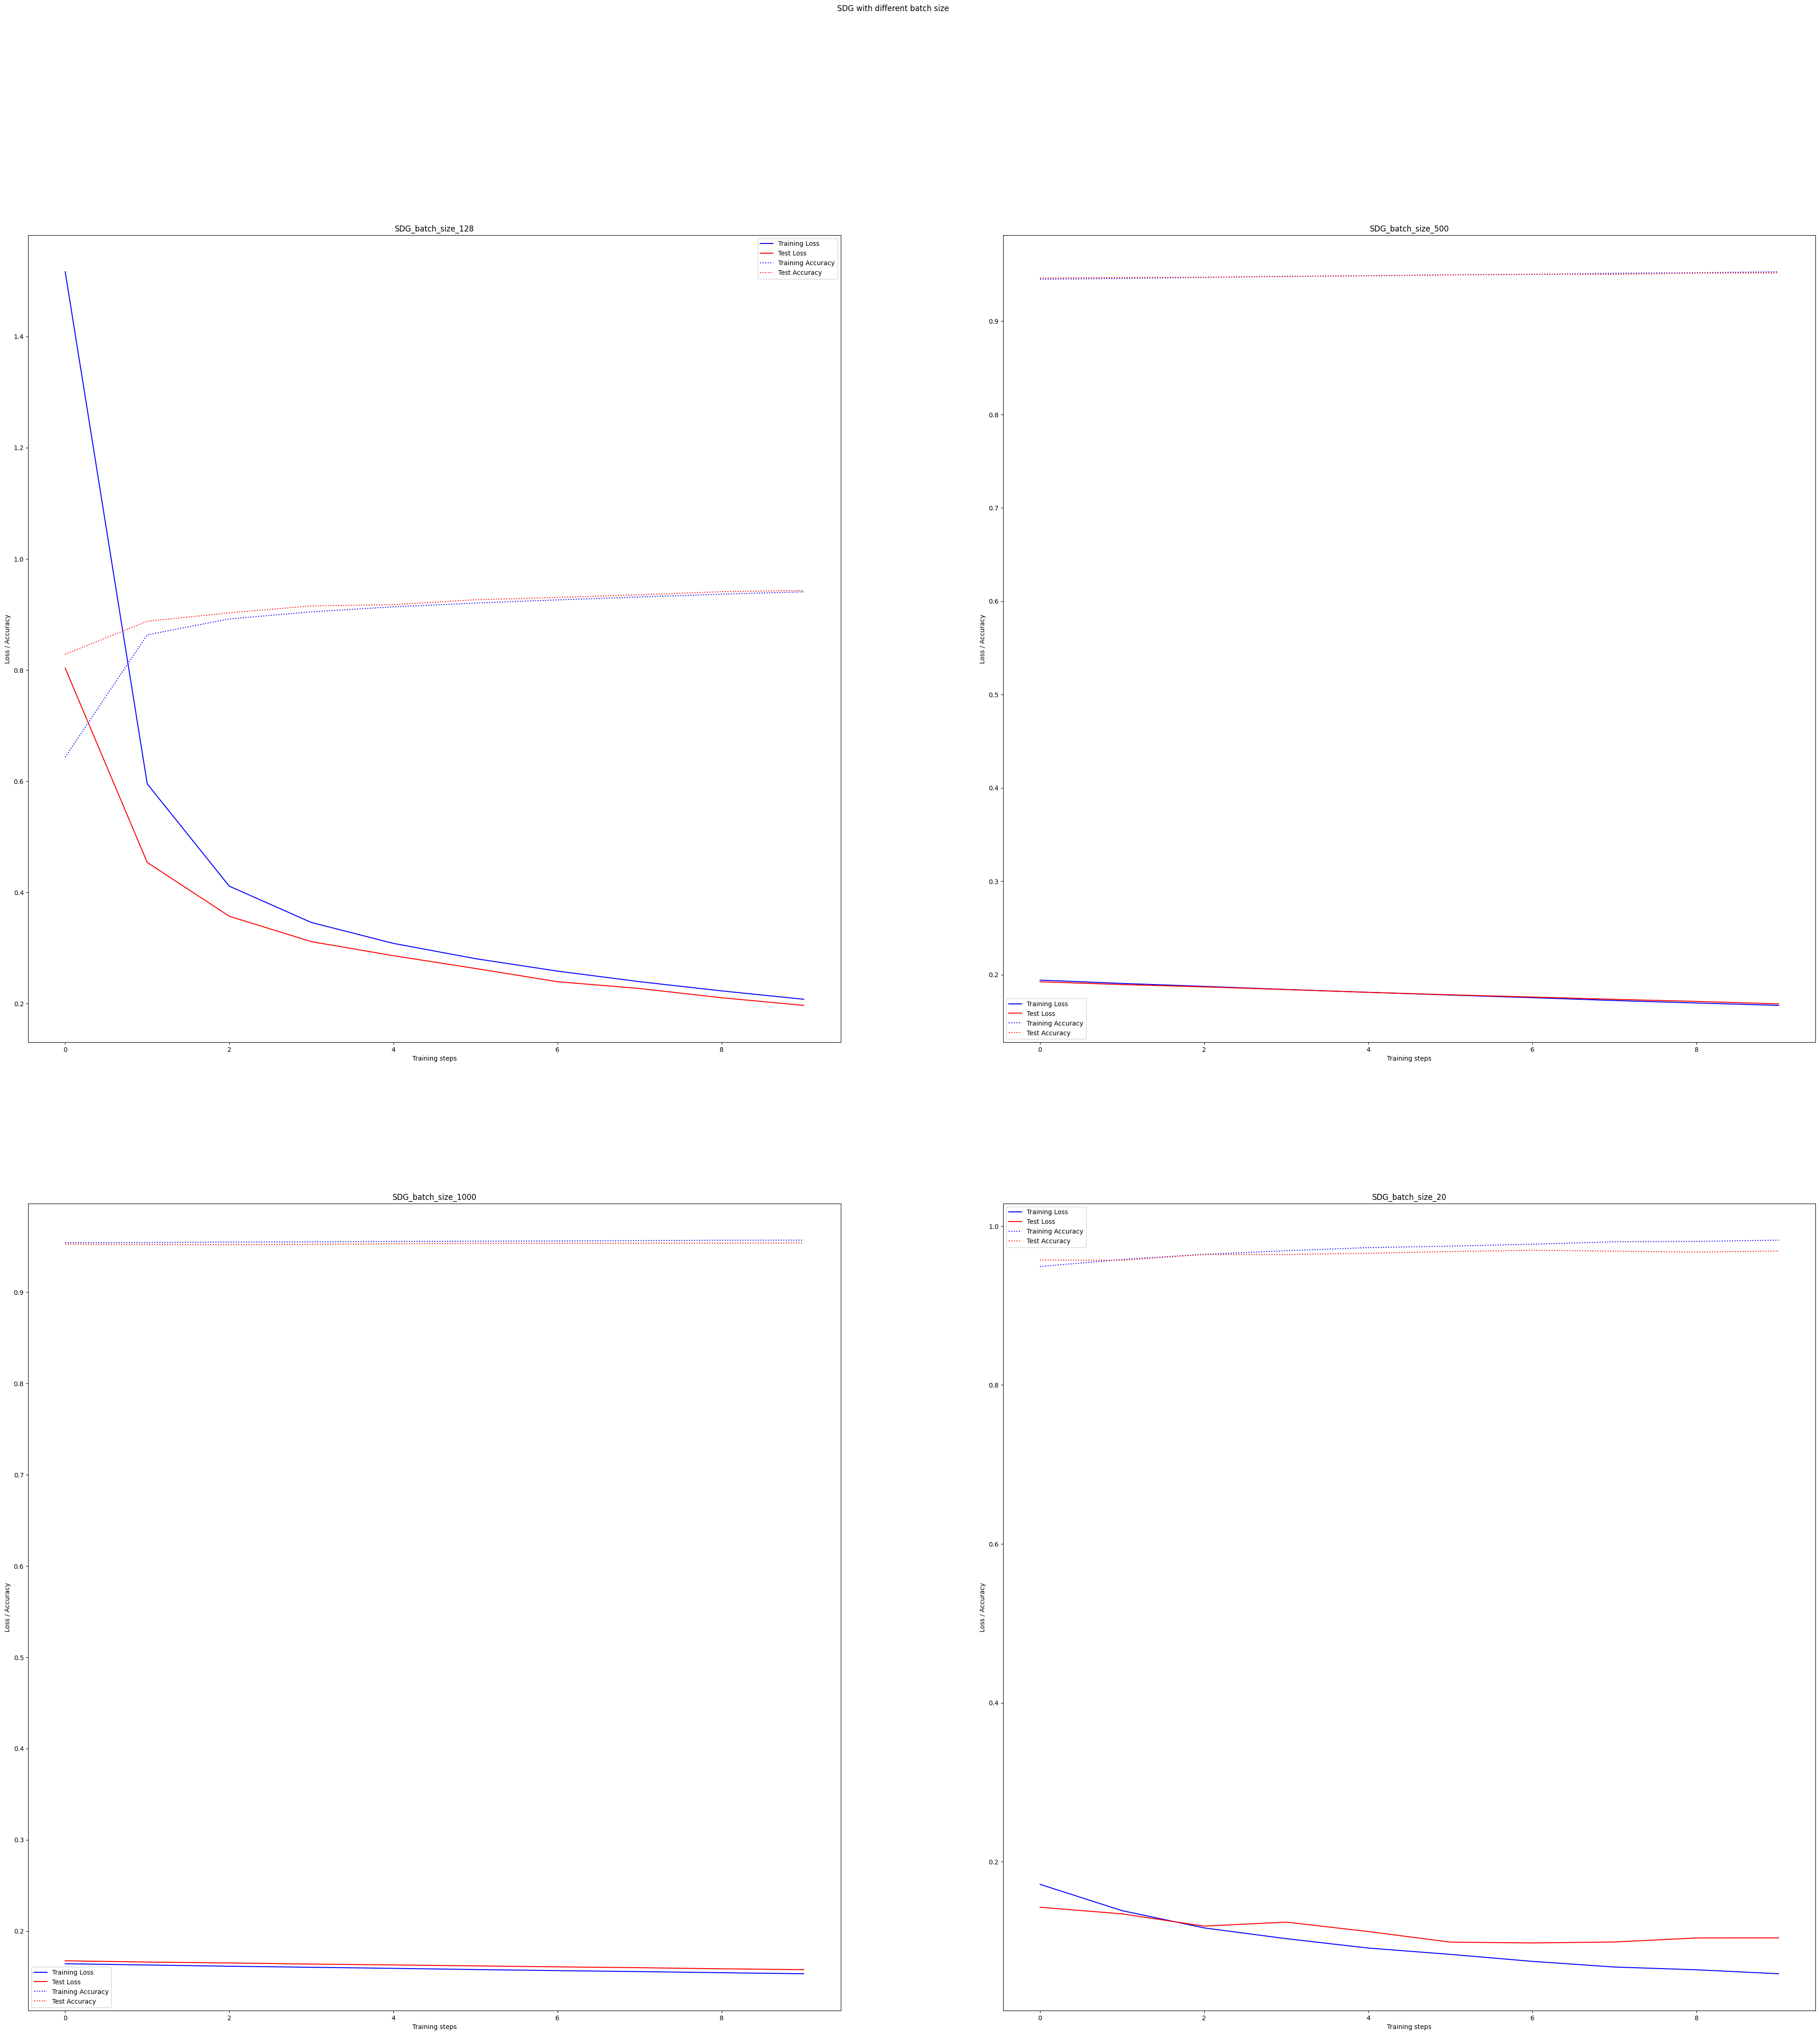

In [ ]:
def diffrent_combinations_ll_and_momentum():
    
    #Diffrent combinations
    print("lower learning rate, higher momentum")
    (train_loss_list5_0, train_accuracy_list5_0, test_loss_list5_0, test_accuracy_list5_0) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9), num_epochs)
    print("higher learning rate, lower momentum")
    (train_loss_list5_1, train_accuracy_list5_1, test_loss_list5_1, test_accuracy_list5_1) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, tf.keras.optimizers.legacy.SGD(learning_rate=0.5, momentum=0.1), num_epochs)
    print("lower learning rate, lower momentum")
    (train_loss_list5_2, train_accuracy_list5_2, test_loss_list5_2, test_accuracy_list5_2) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.1), num_epochs)
    print("higher learning rate, higher momentum")
    (train_loss_list5_3, train_accuracy_list5_3, test_loss_list5_3, test_accuracy_list5_3) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, tf.keras.optimizers.legacy.SGD(learning_rate=0.5, momentum=0.9), num_epochs)

    fig6, ((existing_ax_6_0, existing_ax_6_1), (existing_ax_6_2, existing_ax_6_3)) = plt.subplots(2,2)
    fig6.suptitle("Diffrent combinations")
    fig6.set_size_inches(50, 50)
    visualization(existing_ax_6_0, train_loss_list5_0, train_accuracy_list5_0, test_loss_list5_0, test_accuracy_list5_0, name="lower learning rate, higher momentum")
    visualization(existing_ax_6_1, train_loss_list5_1, train_accuracy_list5_1, test_loss_list5_1, test_accuracy_list5_1, name="higher learning rate, lower momentum")
    visualization(existing_ax_6_2, train_loss_list5_2, train_accuracy_list5_2, test_loss_list5_2, test_accuracy_list5_2, name="lower learning rate, lower momentum")
    visualization(existing_ax_6_3, train_loss_list5_3, train_accuracy_list5_3, test_loss_list5_3, test_accuracy_list5_3, name="higher learning rate, higher momentum")

#diffrent_combinations_ll_and_momentum()


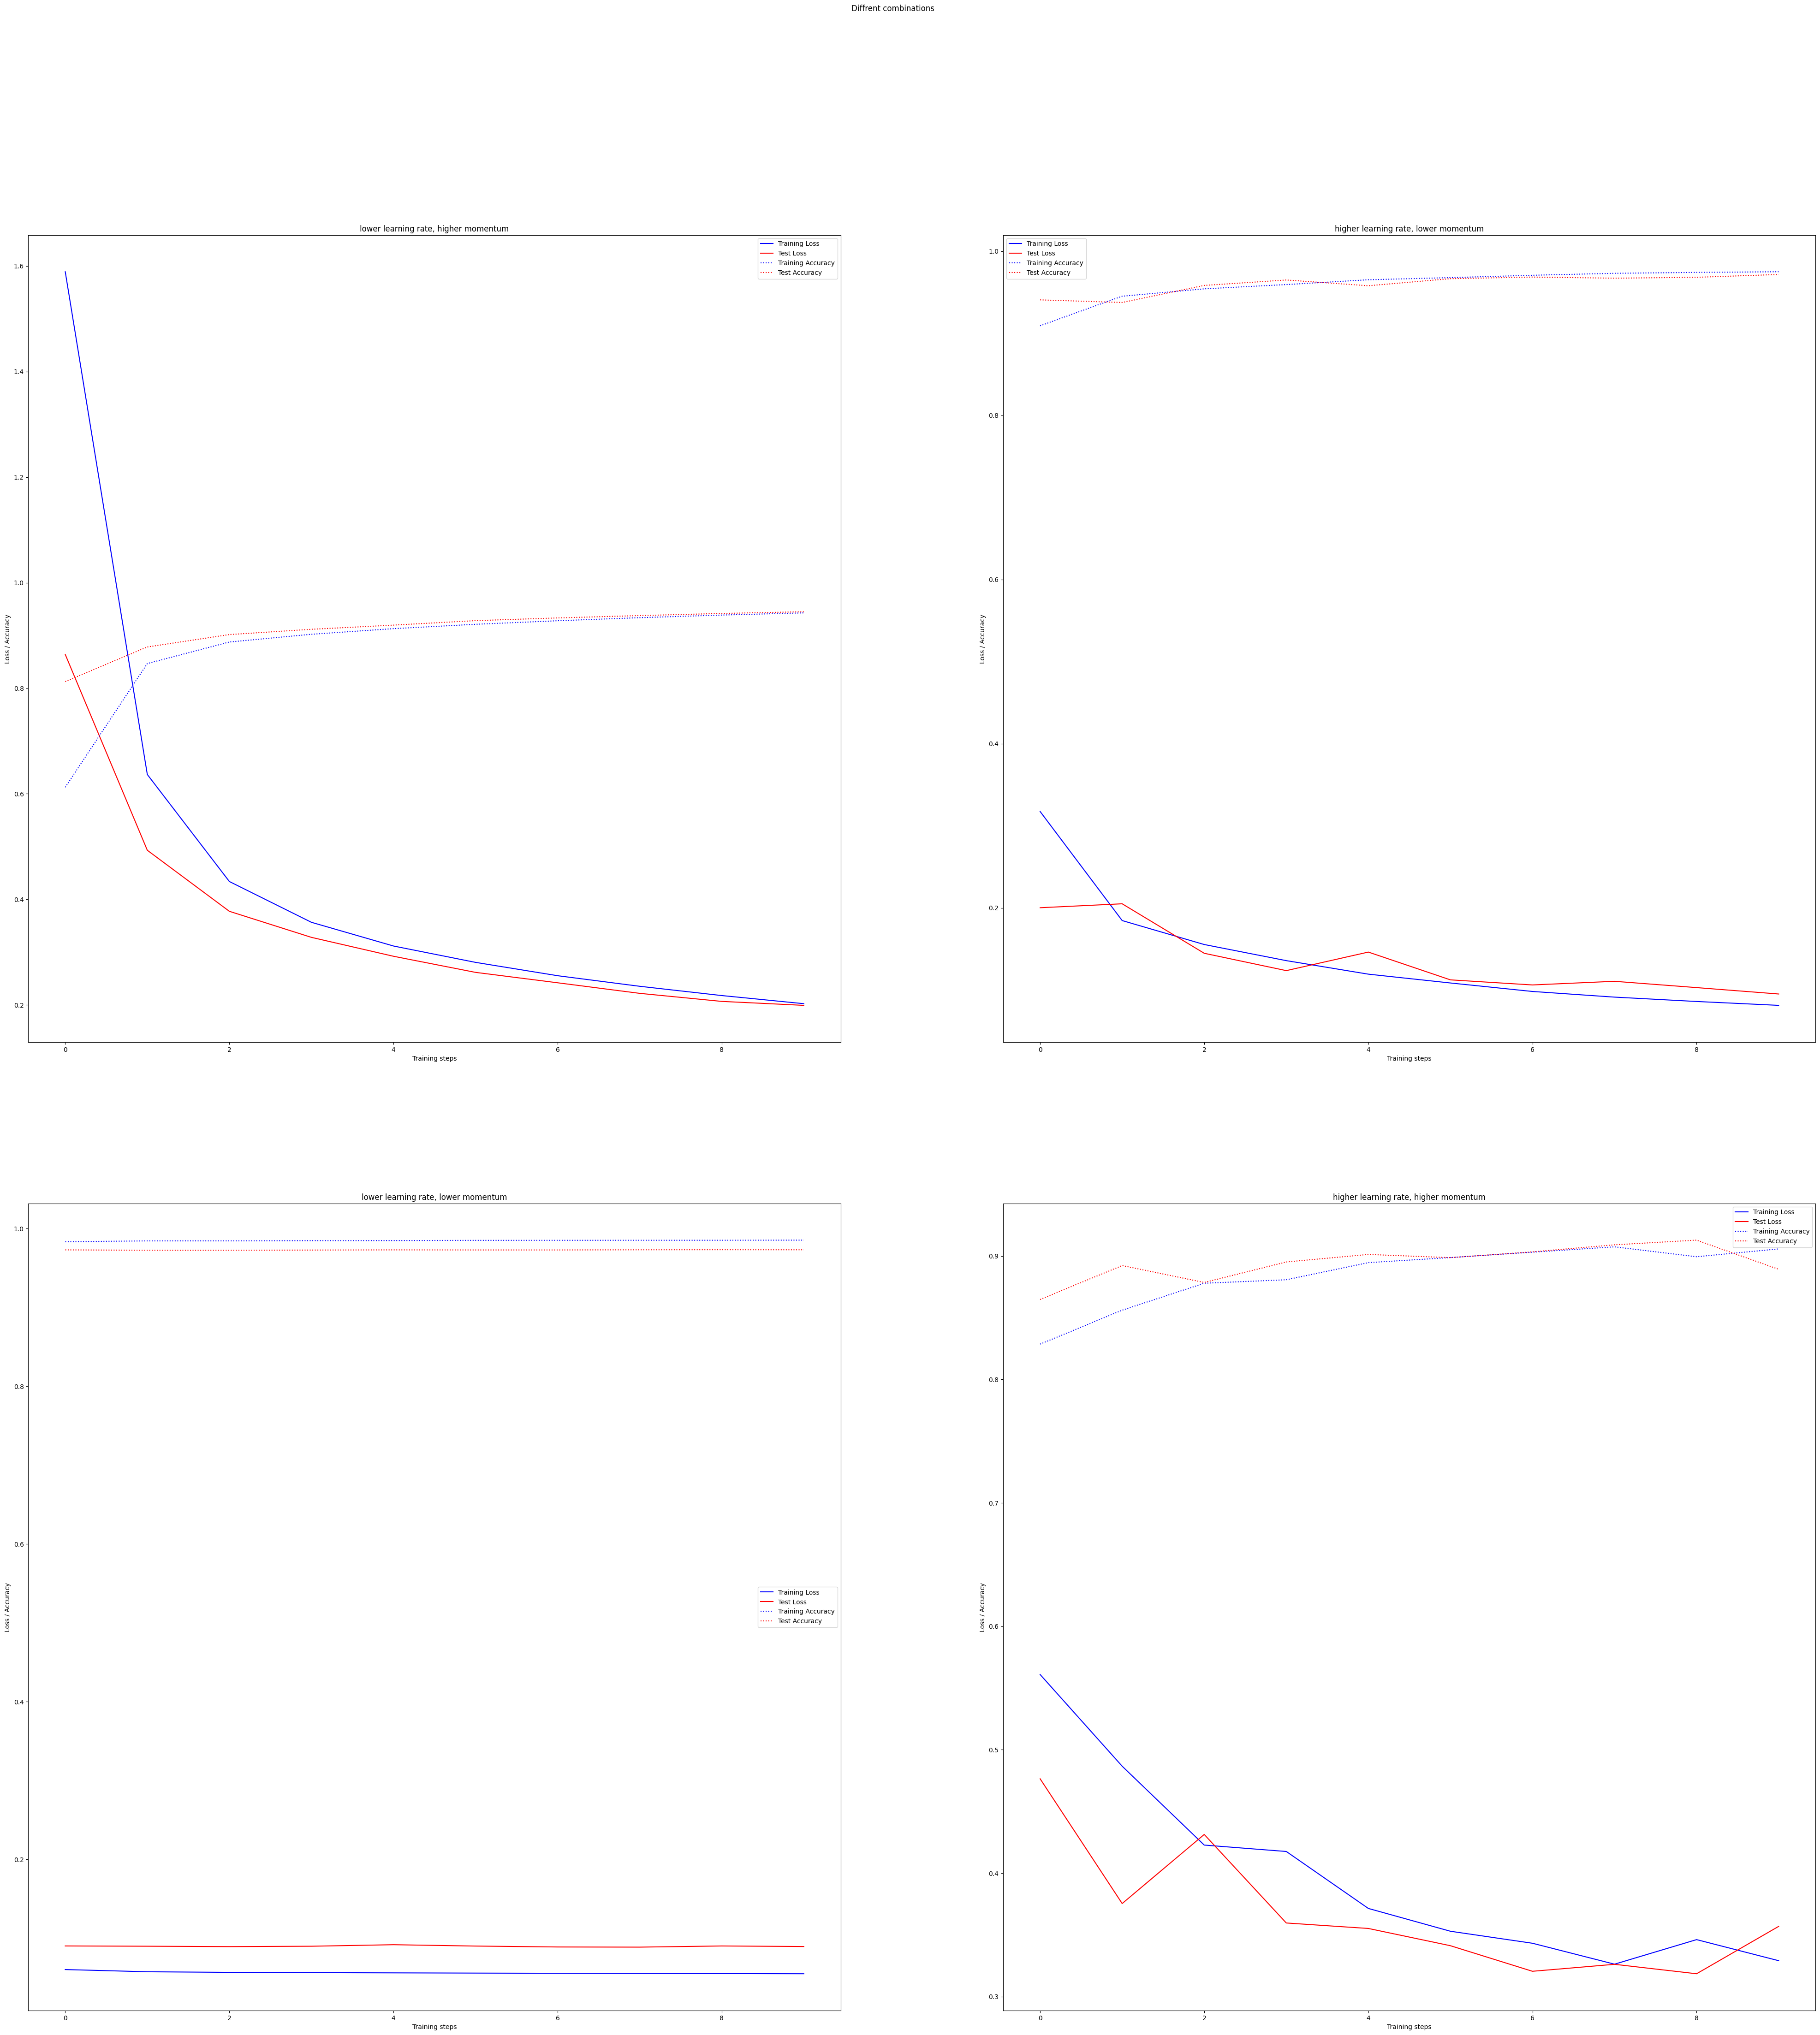

In [ ]:
def diffrent_epochs():
    print("SDG_Model_1_epochs_10")
    (train_loss_list6_0, train_accuracy_list6_0, test_loss_list6_0, test_accuracy_list6_0) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, optimizer_SDF, 10)
    print("SDG_Model_1_epochs_20")
    (train_loss_list6_1, train_accuracy_list6_1, test_loss_list6_1, test_accuracy_list6_1) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, optimizer_SDF, 20)
    print("SDG_Model_1_epochs_50")
    (train_loss_list6_2, train_accuracy_list6_2, test_loss_list6_2, test_accuracy_list6_2) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, optimizer_SDF, 50)
    print("SDG_Model_1_epochs_100")
    (train_loss_list6_3, train_accuracy_list6_3, test_loss_list6_3, test_accuracy_list6_3) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, optimizer_SDF, 100)

    fig7, ((existing_ax_7_0, existing_ax_7_1), (existing_ax_7_2, existing_ax_7_3)) = plt.subplots(2,2)
    fig7.suptitle("SDG with different epochs")
    fig7.set_size_inches(50, 50)
    visualization(existing_ax_7_0, train_loss_list6_0, train_accuracy_list6_0, test_loss_list6_0, test_accuracy_list6_0, name="SDG_Model_1_epochs_10")
    visualization(existing_ax_7_1, train_loss_list6_1, train_accuracy_list6_1, test_loss_list6_1, test_accuracy_list6_1, name="SDG_Model_1_epochs_20")
    visualization(existing_ax_7_2, train_loss_list6_2, train_accuracy_list6_2, test_loss_list6_2, test_accuracy_list6_2, name="SDG_Model_1_epochs_50")
    visualization(existing_ax_7_3, train_loss_list6_3, train_accuracy_list6_3, test_loss_list6_3, test_accuracy_list6_3, name="SDG_Model_1_epochs_100")
    
diffrent_epochs()

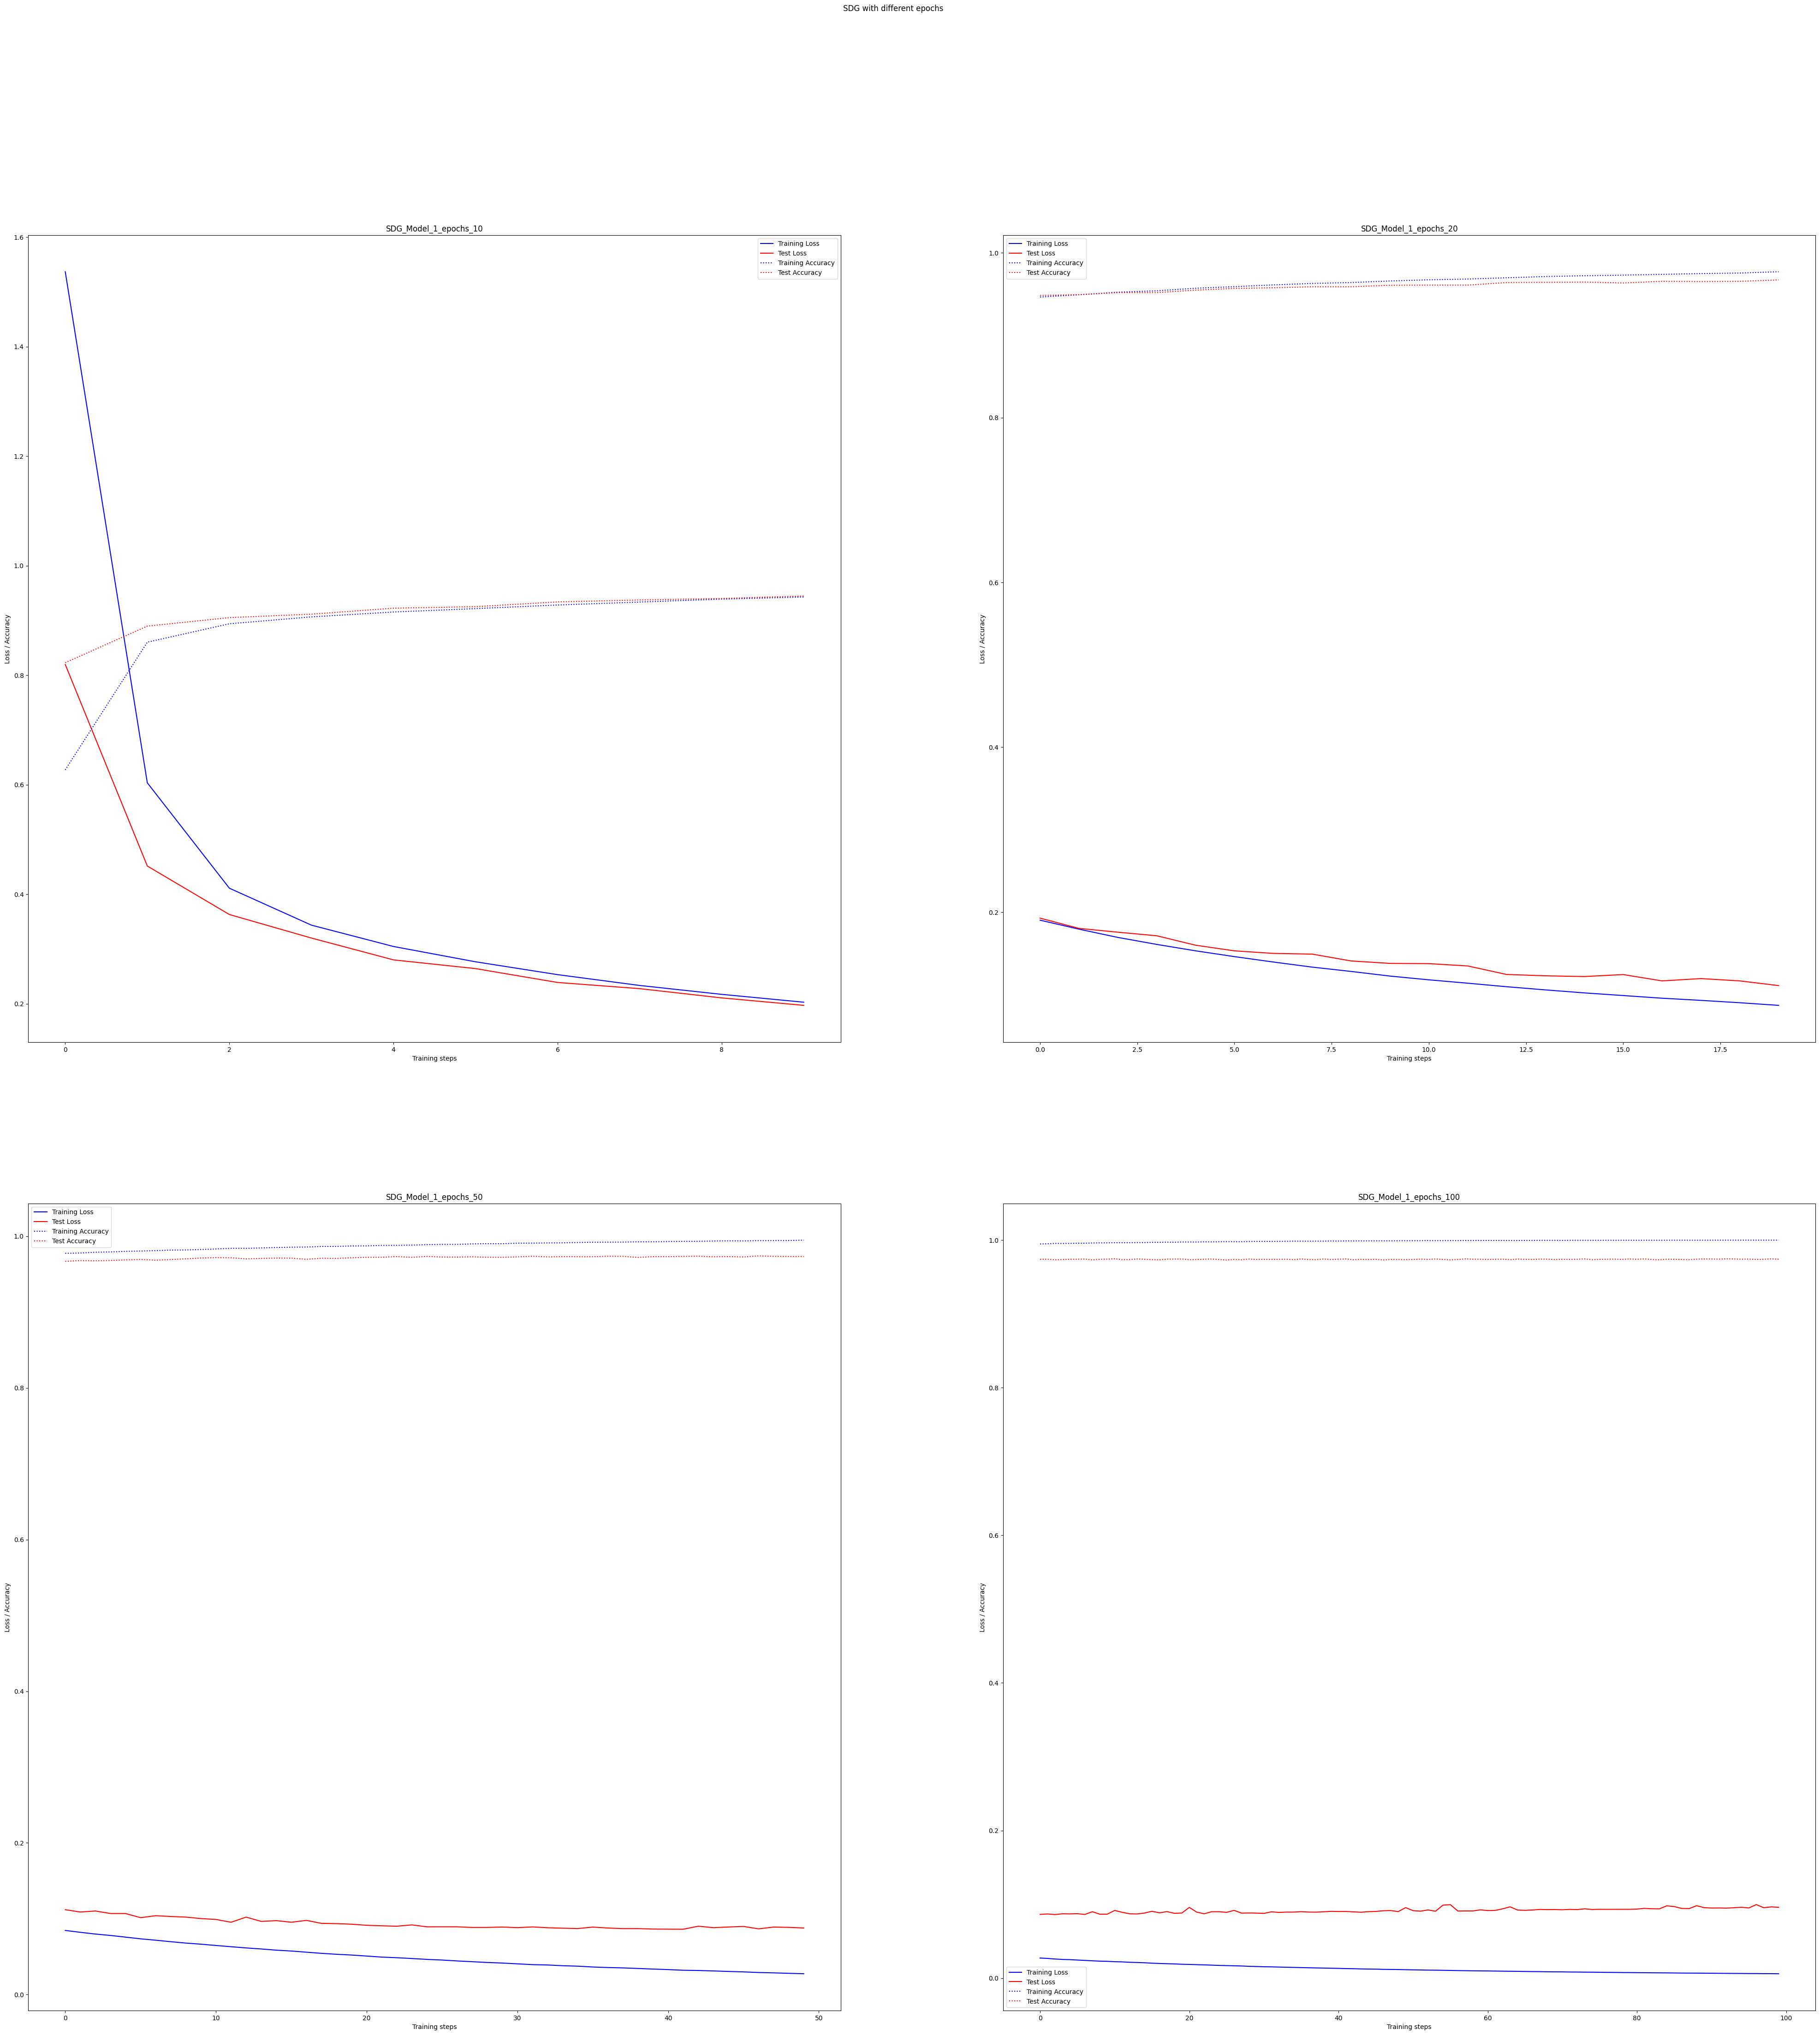

In [ ]:
plt.tight_layout()
plt.show()